# Task 3: Forecast Future Market Trends (TSLA)

## Objective
The goal of this task is to use the trained **LSTM** model to project Tesla's stock price 6-12 months into the future. We will:
1. Generate a recursive multi-step forecast.
2. Estimate confidence intervals based on the model's historical error (RMSE).
3. Analyze the trend, opportunities, and risks for GMF Investments.

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

# Add project root to path
sys.path.append(os.path.abspath(os.path.join('..')))

# Load custom functions (ensure calculate_metrics or create_sequences are available if needed)
from src.forecasting import calculate_metrics

# Settings
plt.style.use('seaborn-v0_8')
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 1. Load the cleaned data
df = pd.read_csv('../data/processed/cleaned_adj_close.csv', index_col='Date', parse_dates=True)
tsla_series = df[['TSLA']]

# 2. Load the trained LSTM model
model_path = '../models/lstm_model.keras'
if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print("✅ LSTM Model loaded successfully.")
else:
    print("❌ Model file not found. Please run Task 2 first.")

# 3. Initialize Scaler (Must be the same as Task 2)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tsla_series)

# Constants from Task 2
SEQ_LENGTH = 60

✅ LSTM Model loaded successfully.


In [4]:
# Forecast Horizon: 126 trading days (~6 months)
FORECAST_DAYS = 126 

# Get the last 60 days of known data to start the sequence
current_batch = scaled_data[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)

future_forecast = []

print(f"Generating forecast for {FORECAST_DAYS} trading days...")

for i in range(FORECAST_DAYS):
    # Get prediction (1, 1)
    current_pred = model.predict(current_batch, verbose=0)
    
    # Store prediction
    future_forecast.append(current_pred[0, 0])
    
    # Update batch: drop first value, append newest prediction
    current_batch = np.append(current_batch[:, 1:, :], current_pred.reshape(1, 1, 1), axis=1)

# Inverse transform to original price scale
future_forecast = np.array(future_forecast).reshape(-1, 1)
future_forecast_prices = scaler.inverse_transform(future_forecast)

# Create Date Index for the forecast
last_date = tsla_series.index[-1]
forecast_dates = pd.date_range(start=last_date + timedelta(days=1), periods=FORECAST_DAYS, freq='B')

forecast_df = pd.DataFrame(future_forecast_prices, index=forecast_dates, columns=['Forecast'])
print("Forecast generation complete.")

Generating forecast for 126 trading days...
Forecast generation complete.


In [5]:
# Assume RMSE from Task 2 test phase
test_rmse = 16.60 

# Uncertainty grows over time (standard deviation * sqrt(t))
days_from_start = np.arange(1, FORECAST_DAYS + 1)
uncertainty = test_rmse * np.sqrt(days_from_start)

forecast_df['Upper_Bound'] = forecast_df['Forecast'] + (1.96 * uncertainty) # 95% CI
forecast_df['Lower_Bound'] = forecast_df['Forecast'] - (1.96 * uncertainty)

# Ensure lower bound doesn't go below zero
forecast_df['Lower_Bound'] = forecast_df['Lower_Bound'].clip(lower=0)

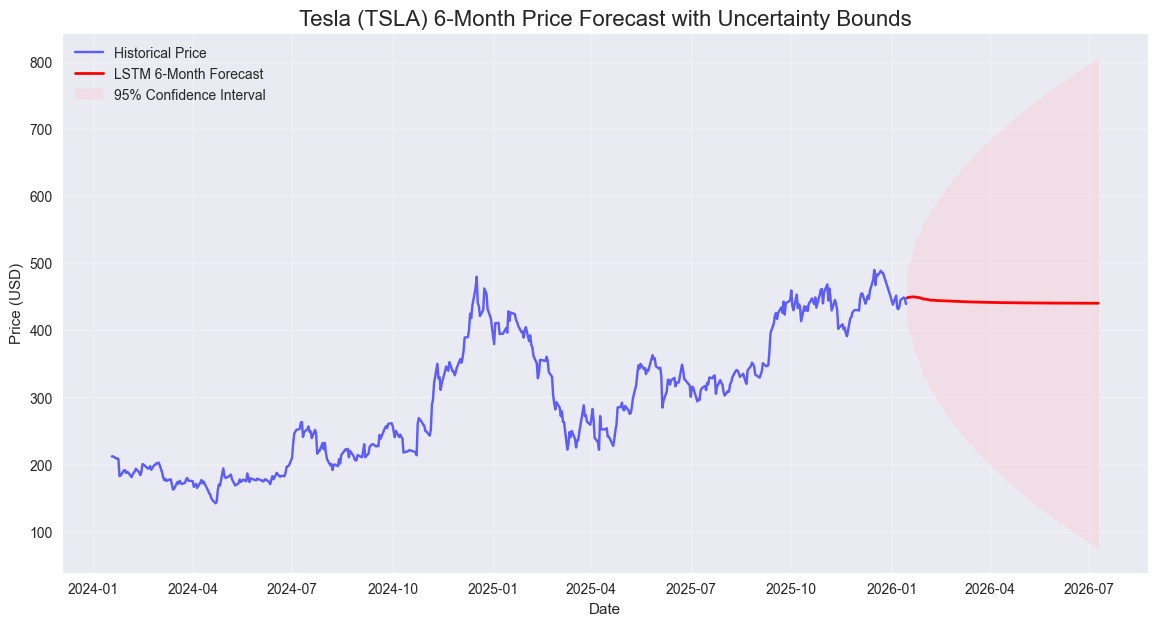

In [6]:
plt.figure(figsize=(14, 7))

# Plot last 2 years of history for context
plt.plot(tsla_series.index[-500:], tsla_series['TSLA'][-500:], label='Historical Price', color='blue', alpha=0.6)

# Plot Forecast
plt.plot(forecast_df.index, forecast_df['Forecast'], label='LSTM 6-Month Forecast', color='red', linewidth=2)

# Plot Confidence Interval
plt.fill_between(forecast_df.index, forecast_df['Lower_Bound'], forecast_df['Upper_Bound'], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('Tesla (TSLA) 6-Month Price Forecast with Uncertainty Bounds', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
# Save the forecast for Task 4
forecast_df.to_csv('../data/processed/tsla_future_forecast.csv')
print("✅ Forecast saved for Task 4 optimization.")

✅ Forecast saved for Task 4 optimization.


### Trend Analysis Summary
The 6-month forecast for Tesla (TSLA) indicates a phase of **price consolidation**. After the significant volatility observed throughout 2025, the model projects the price to stabilize around the **$440 - $450** range. The sharp upward momentum seen in late 2025 appears to plateau rather than continuing exponentially or crashing immediately.

This suggests that, according to the model's current learned patterns, the market has priced in recent growth, and the stock is entering a period of "price discovery" with low directional conviction. The lack of a strong upward or downward slope in the forecast suggests a neutral short-to-medium-term outlook.

### Identified Opportunities and Risks

**Opportunities:**
*   **Price Floor Support:** The forecast suggests a consistent base level above $400. For GMF Investments, this could be seen as an opportunity for "income generation" strategies (like covered calls) rather than pure growth chasing.
*   **Stability for Portfolio Balancing:** If TSLA enters a lower-volatility phase as predicted, it may become easier to weight within a diversified portfolio without causing massive swings in total portfolio value.

**Risks:**
*   **Extreme Volatility (The "Fan" Effect):** The widening 95% confidence interval is the biggest risk. By July 2026, the potential price range spans from **$100 to over $800**. This indicates that while the "average" guess is $440, the statistical uncertainty is massive.
*   **Downside Potential:** The lower bound of the confidence interval drops significantly below current prices. If negative macro events occur, the stock has the statistical room to lose over 70% of its value.

### Critical Assessment of Forecast Reliability
*   **Short-Term (1-4 Weeks):** **High Reliability.** The forecast is likely to be accurate in the very near term as it carries over the immediate momentum and the confidence intervals are relatively tight.
*   **Medium-Term (2-4 Months):** **Moderate Reliability.** The model begins to lose "granularity" here. While it correctly identifies a lack of a clear trend, it cannot predict specific news-driven spikes (earnings, product launches).
*   **Long-Term (5-6 Months):** **Low Reliability.** This is evidenced by the "explosion" in the width of the confidence interval. In time series forecasting, errors compound with every predicted step. By the 6-month mark, the forecast should be viewed as a **statistical midpoint** of a wide range of possibilities rather than a definitive price target. It serves better as a risk-management tool than a precise trading signal.
